In [1]:
import mailbox
from datetime import datetime
from datetime import timedelta
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

In [2]:
email_df = pd.read_csv('/srv/zooniverse/tables/emails.csv')
category_df = pd.read_csv('/srv/zooniverse/tables/project_categories_3-12-19.csv')
project_df = pd.read_csv('/srv/zooniverse/tables/all_projects_table_02-18-19.csv')

In [3]:
# only use "official" projects and classifications
project_df = project_df.loc[(project_df['panoptes_api_official_project'] == 1)]

# only include panoptes projects that also have classification data
project_df = project_df.loc[(project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 1)]

# convert email timestamp to datetime
email_df['date'] = pd.to_datetime(email_df['date'])

In [4]:
# get names of projects for which we have email, category, and classification data
overlapping_projects = category_df.loc[(category_df['project_name'].str.lower().isin(project_df['panoptes_project_name'].str.lower())) & (category_df['project_name'].str.lower().isin(email_df['project'].str.lower()))][['project_name']]

In [5]:
# load classification df
classification_df = pd.read_csv('/srv/zooniverse/tables/all_classifications_table_02-18-19.csv')

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# only use "official" projects and classifications
classification_df = classification_df.loc[classification_df['panoptes_api_official_project'] == 1]

# add name column to classification_df
classification_df = classification_df.merge(project_df[['panoptes_project_name','panoptes_project_id']],on='panoptes_project_id')

# online use projects with email, category, and classification data
classification_df = classification_df.loc[classification_df['panoptes_project_name'].str.lower().isin(overlapping_projects['project_name'].str.lower())]

# convert classification timestamp to datetime
classification_df['created_at'] = pd.to_datetime(classification_df['created_at'])

In [7]:
def get_weeks(x):
    return x.isocalendar()[0]*52+x.isocalendar()[1]

classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)
email_df['iso_week'] = email_df['date'].apply(get_weeks)

In [8]:
def count_classifications_per_week(classification_df):
    # grouby weeks and count classifications per week
    classifications_by_week = classification_df.groupby(['panoptes_project_name','iso_week'])['iso_week'].size().to_frame('classifications')
    # reindex to fill missing values
    classifications_by_week = classifications_by_week.reindex(pd.MultiIndex.from_product(classifications_by_week.index.levels, names=classifications_by_week.index.names))
    classifications_by_week.reset_index(inplace=True)
    # switch NaN to 0
    classifications_by_week['classifications'] = classifications_by_week['classifications'].fillna(0)
    return classifications_by_week

# grouby weeks and count classifications per week
classifications_by_week = count_classifications_per_week(classification_df)

In [9]:
def get_weeks(x):
    return x.isocalendar()[0]*52+x.isocalendar()[1]

def classifications_by_time(classifications_by_week, email_df, title=None):
    classifications_by_week.plot(x='iso_week',y='classifications',figsize=(12,6))
    
    plt.vlines(x=email_df.loc[email_df['iso_week'] < classifications_by_week['iso_week'].max()]['iso_week'].tolist(),
               ymin=0,
               ymax=classifications_by_week['classifications'].max(),
               linestyles='dashed',
               lw=1)
    
    plt.xlabel('ISO Date (Years * 52 + Weeks)')
    plt.ylabel('Number of Classifications')
    plt.tight_layout()
    
    if title:
        plt.title(title)

# Time series for each project, showing number of classifications per week.

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


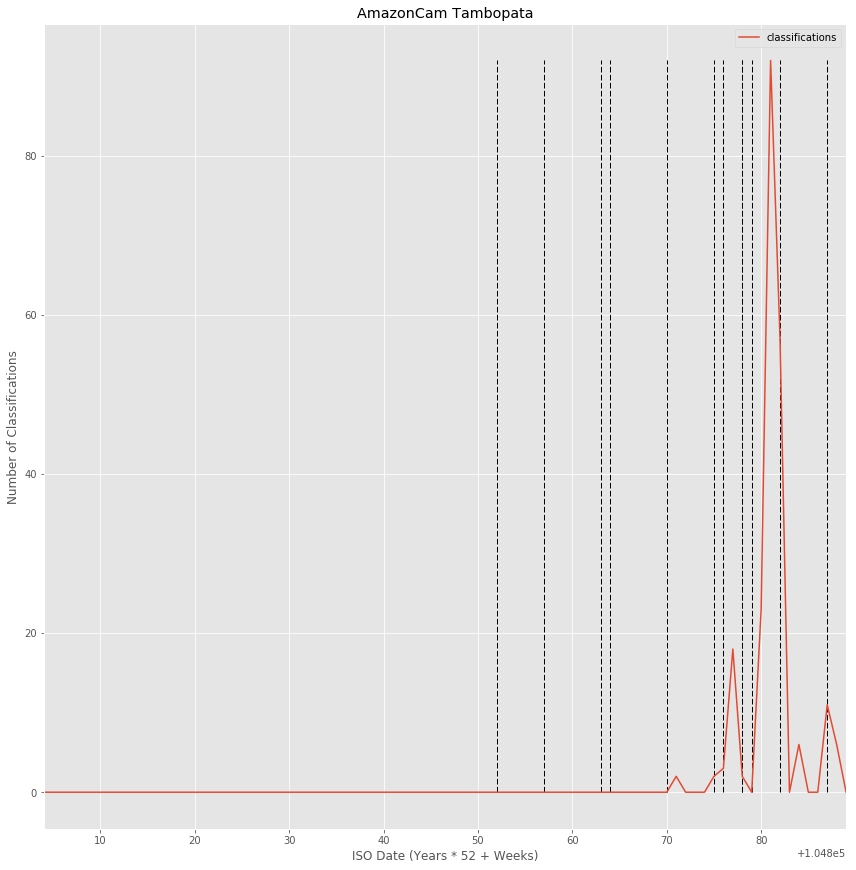

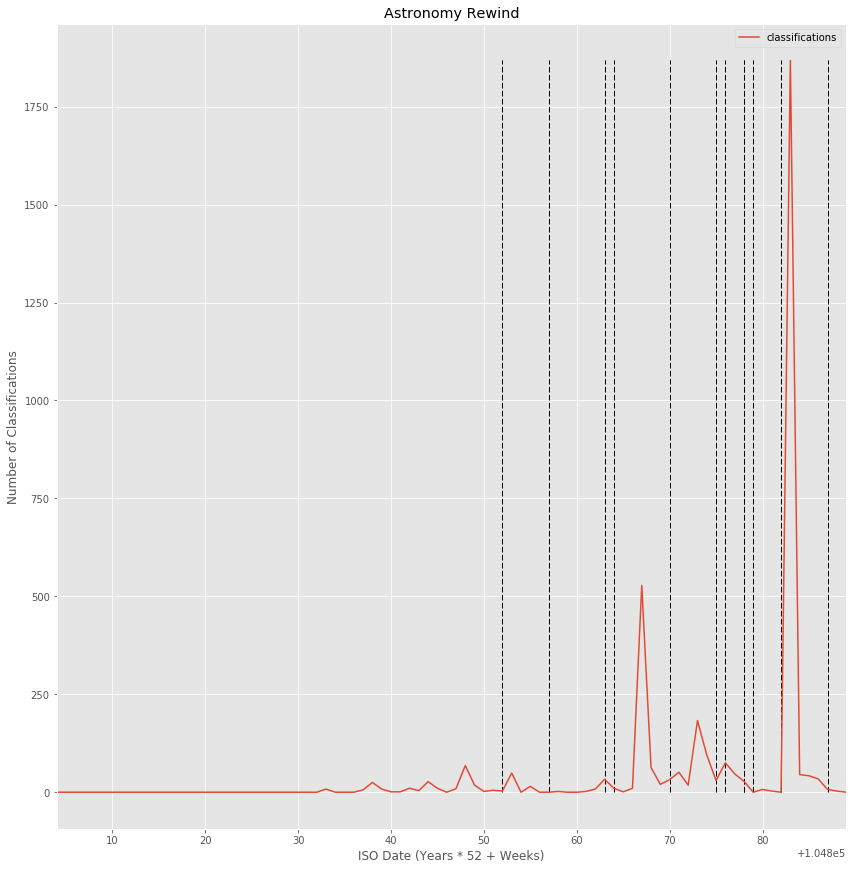

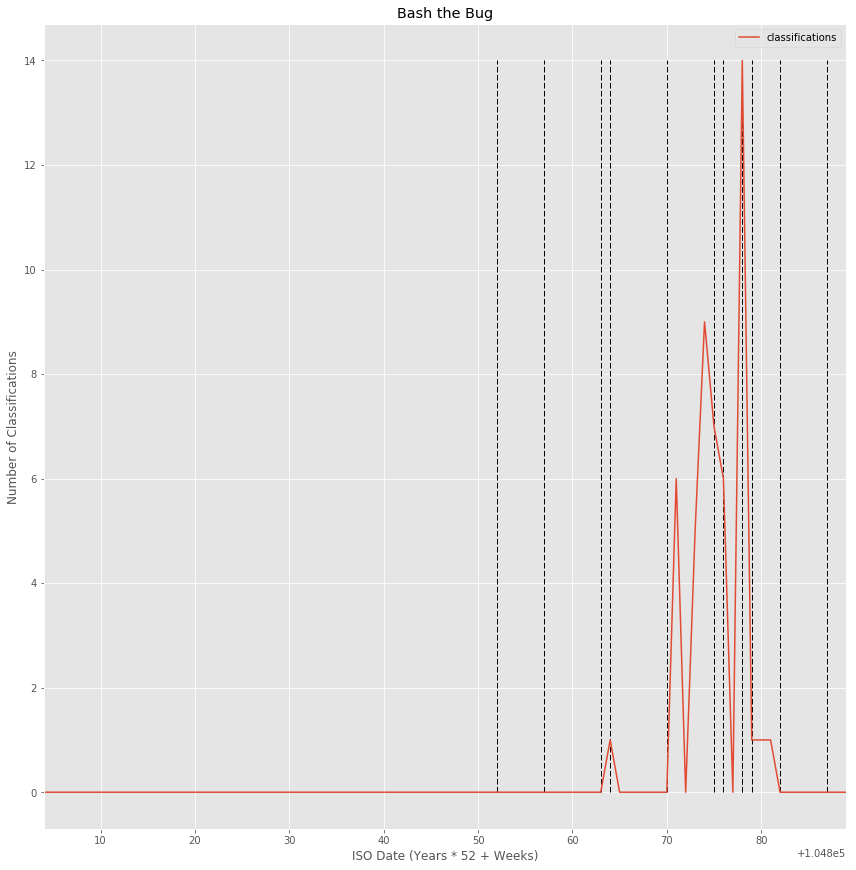

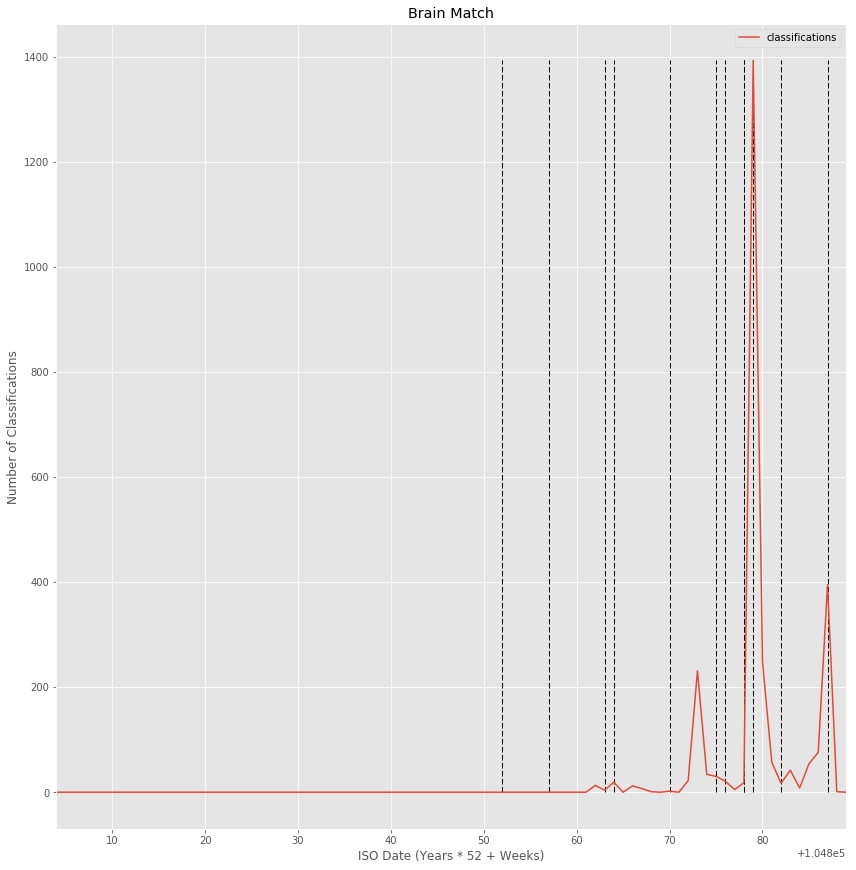

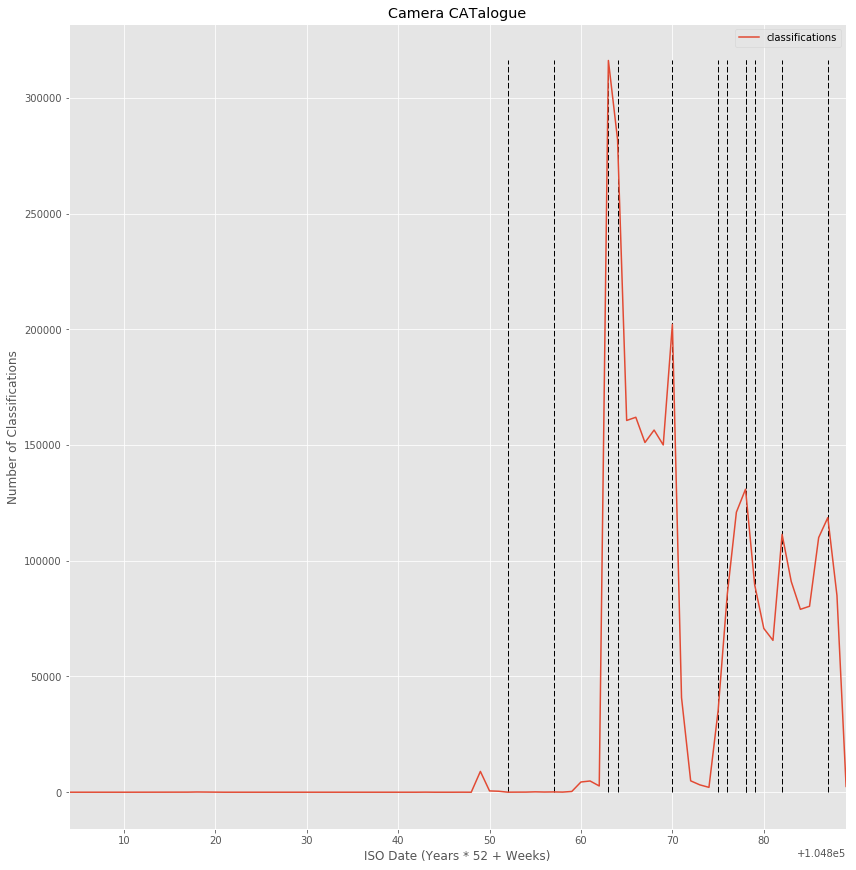

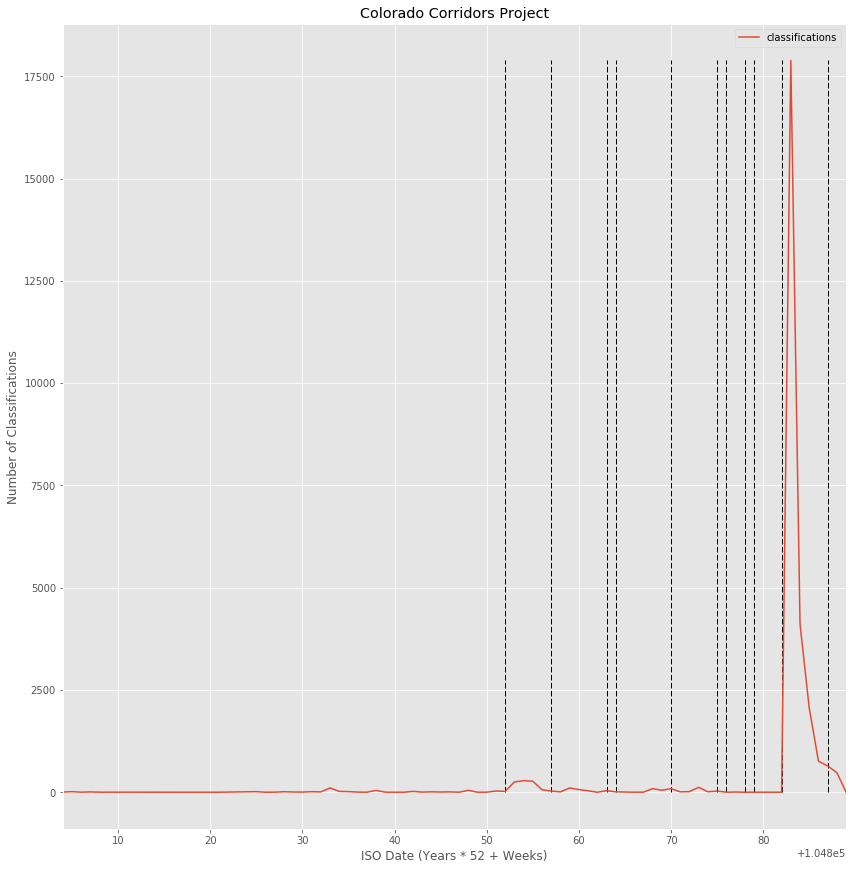

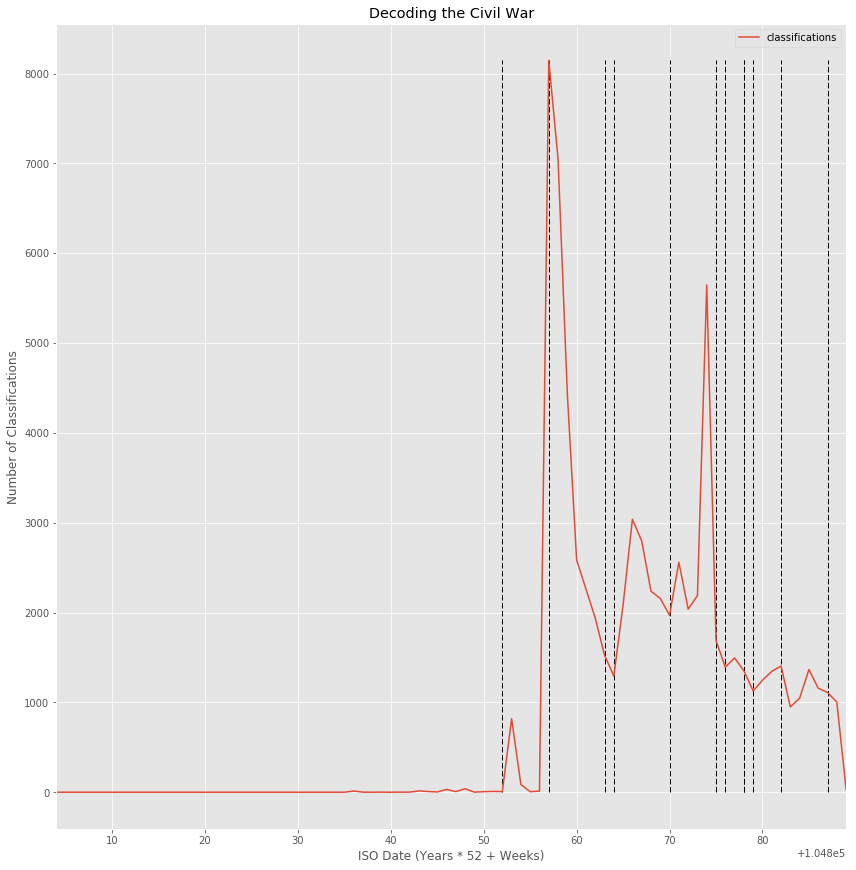

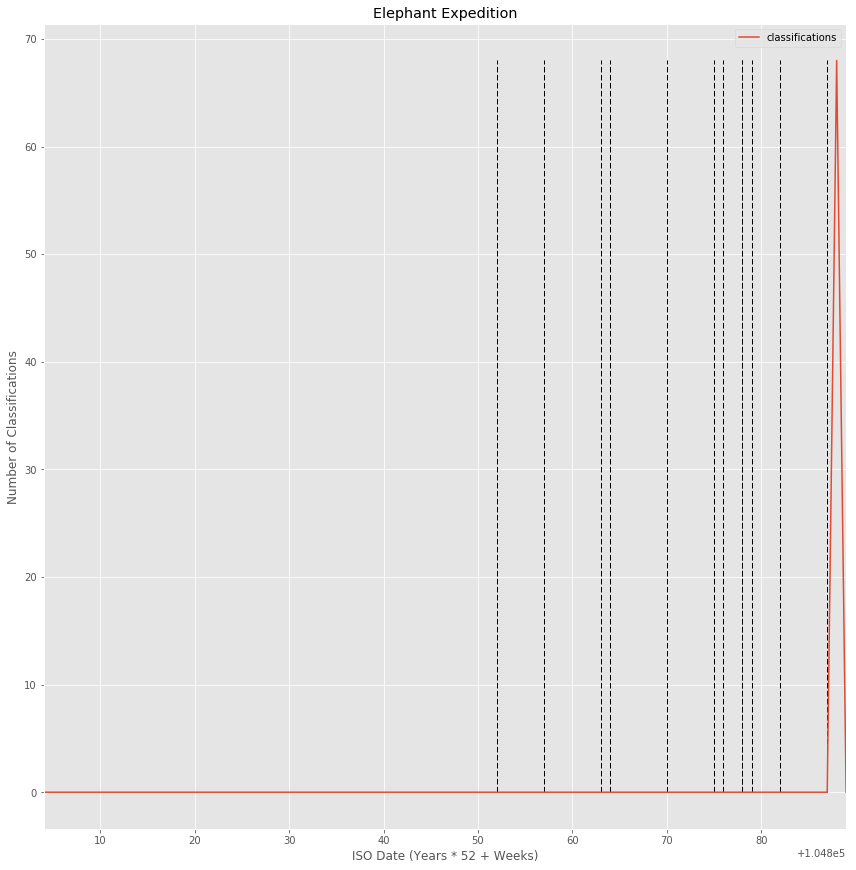

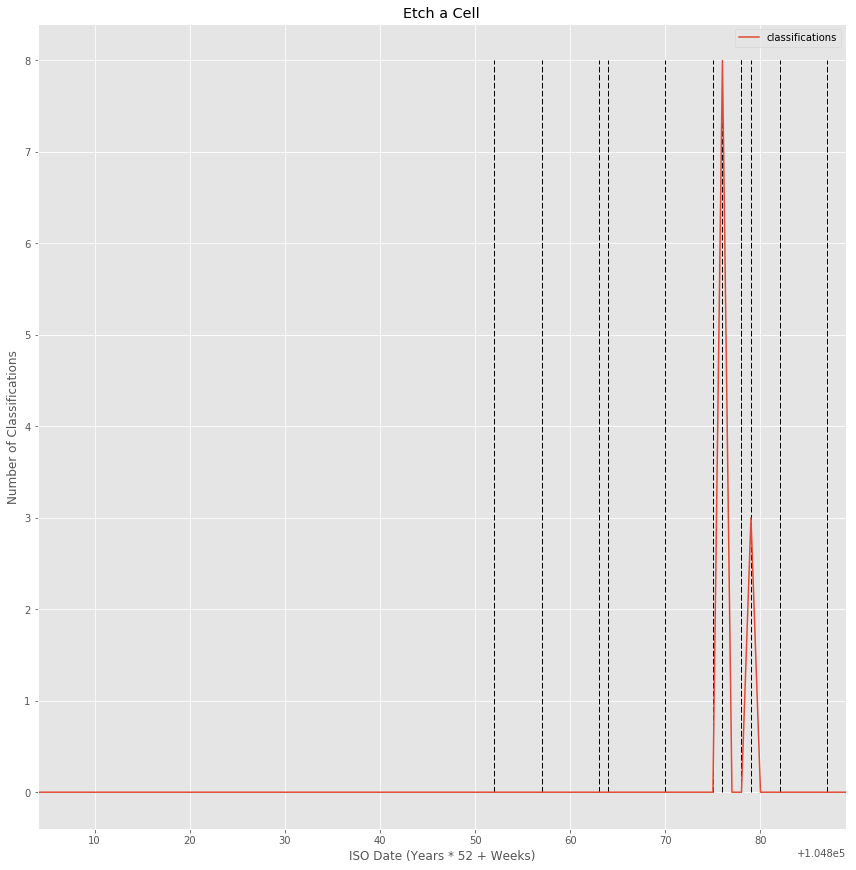

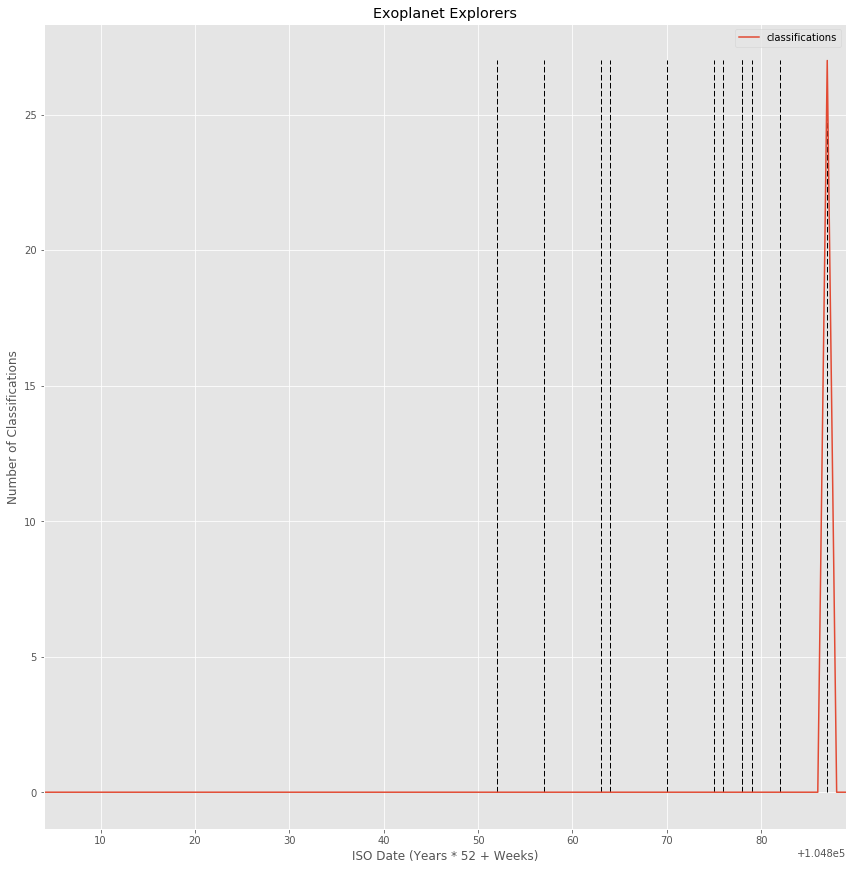

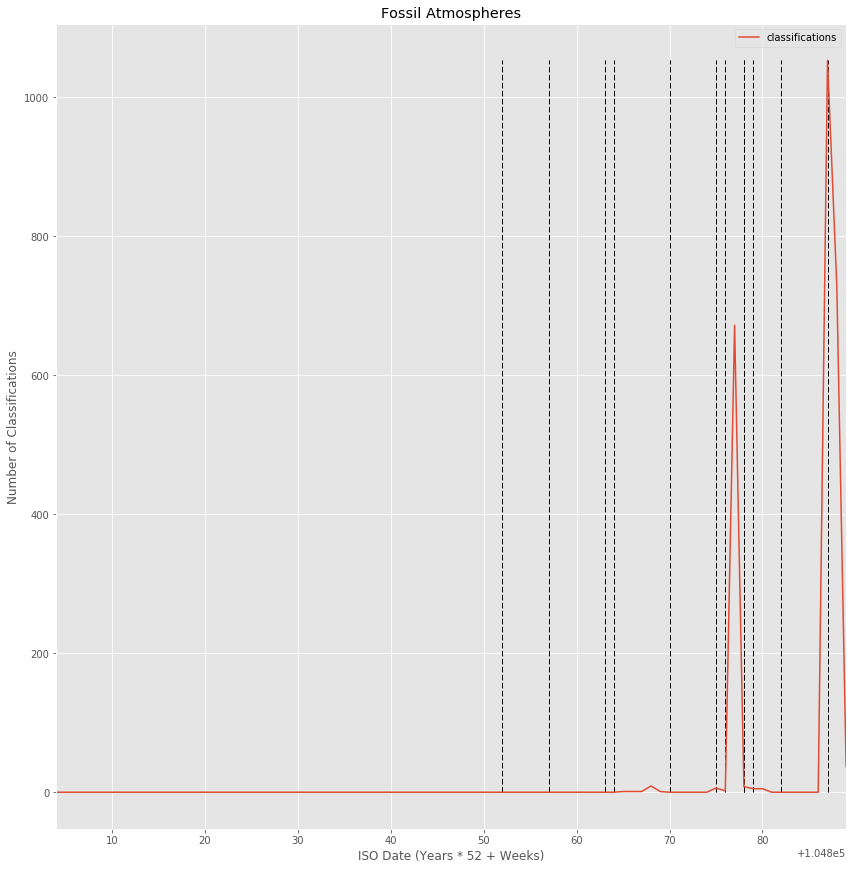

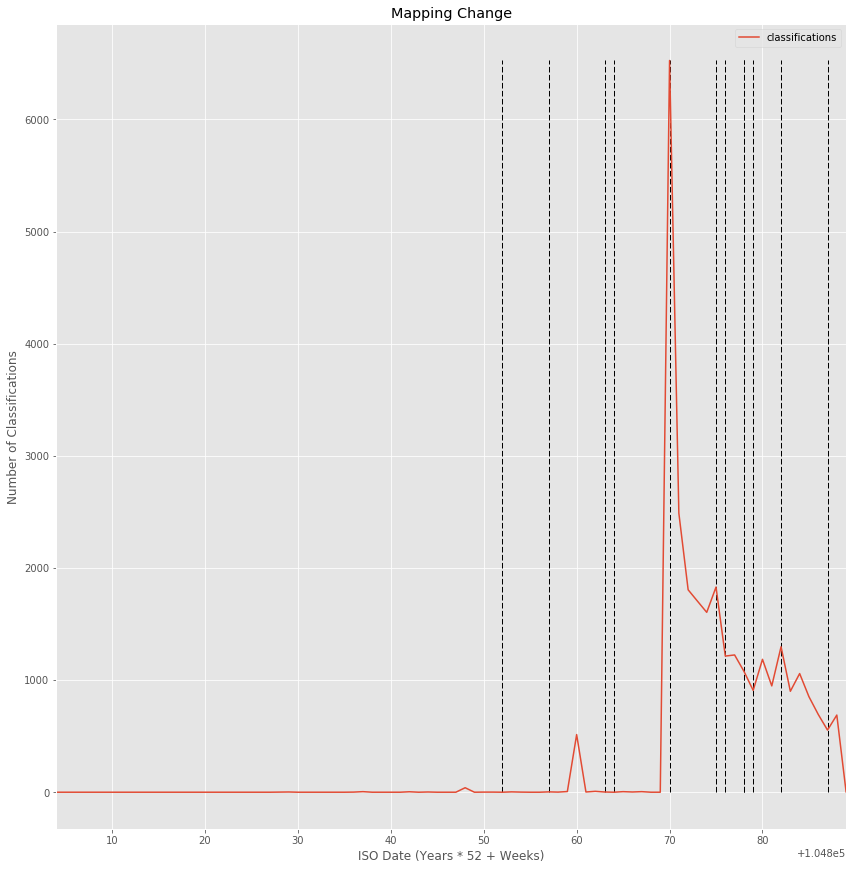

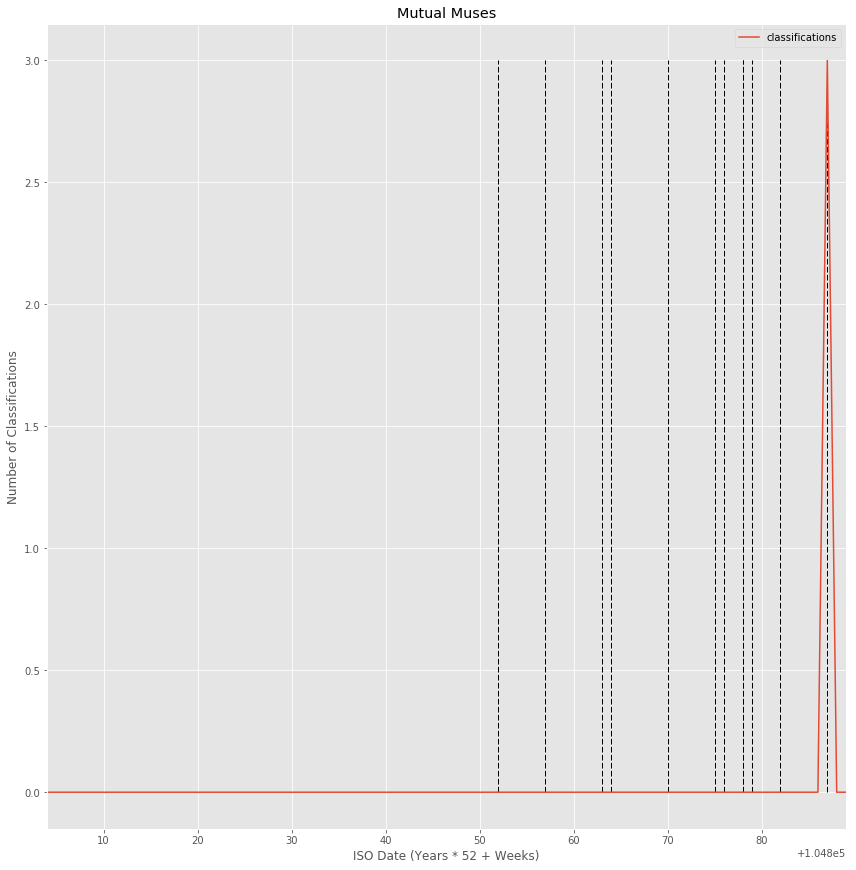

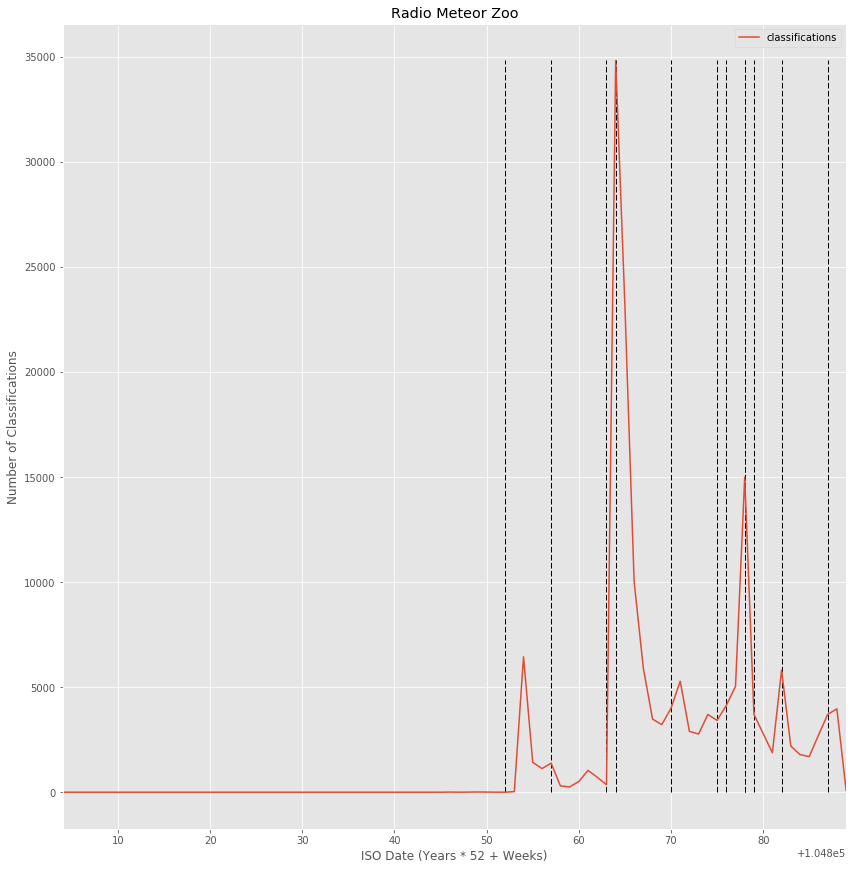

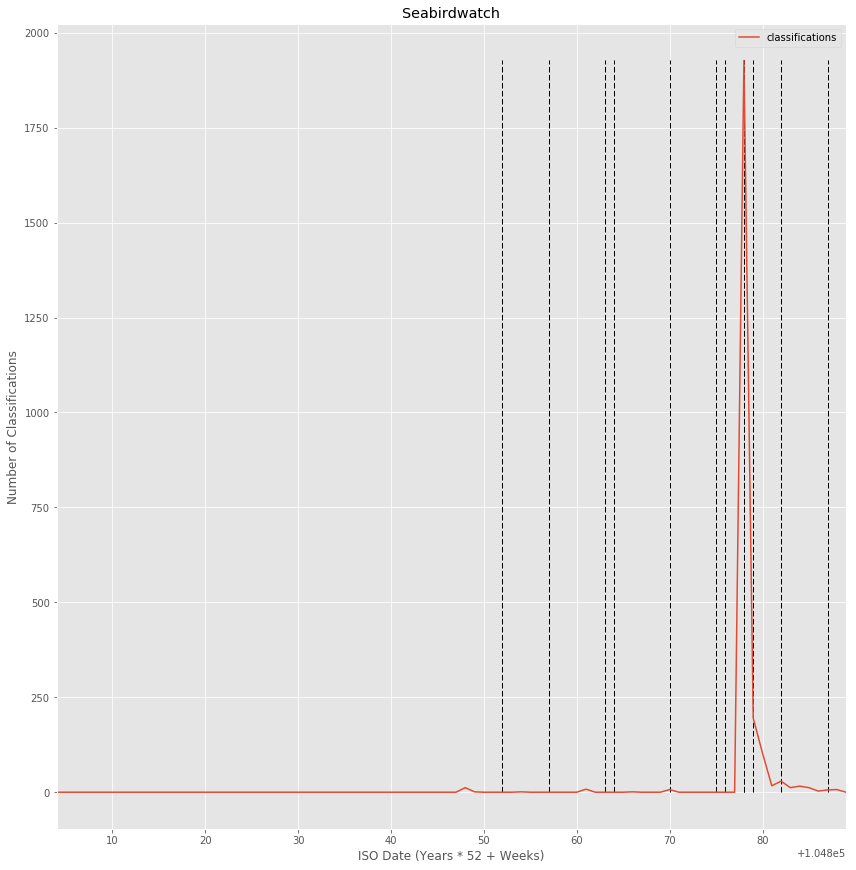

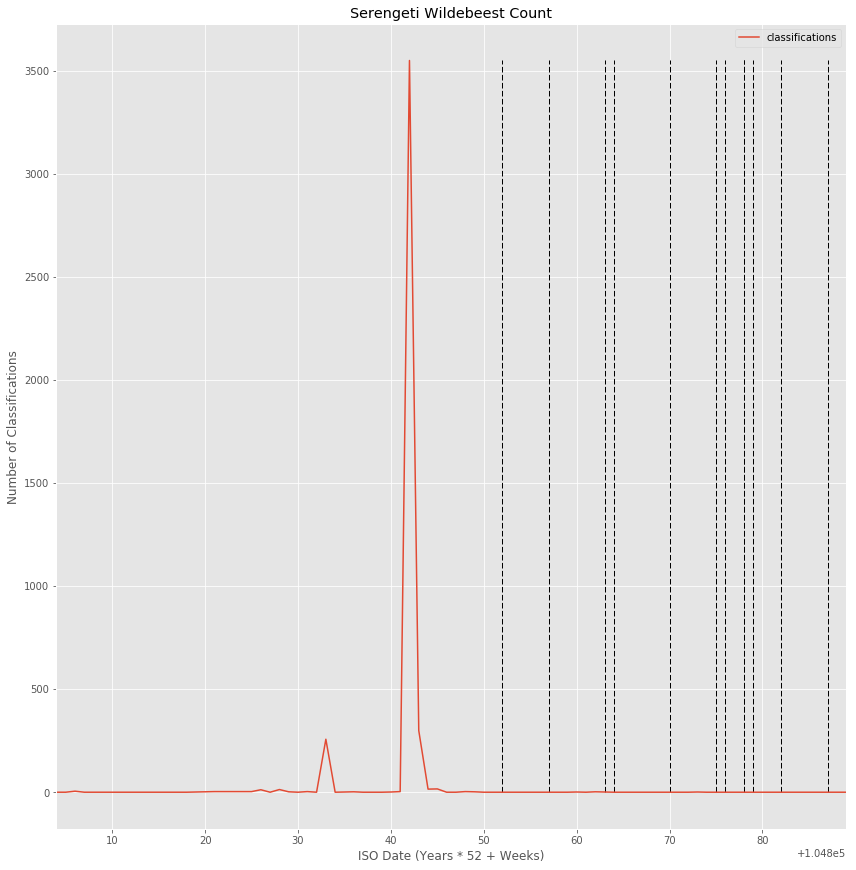

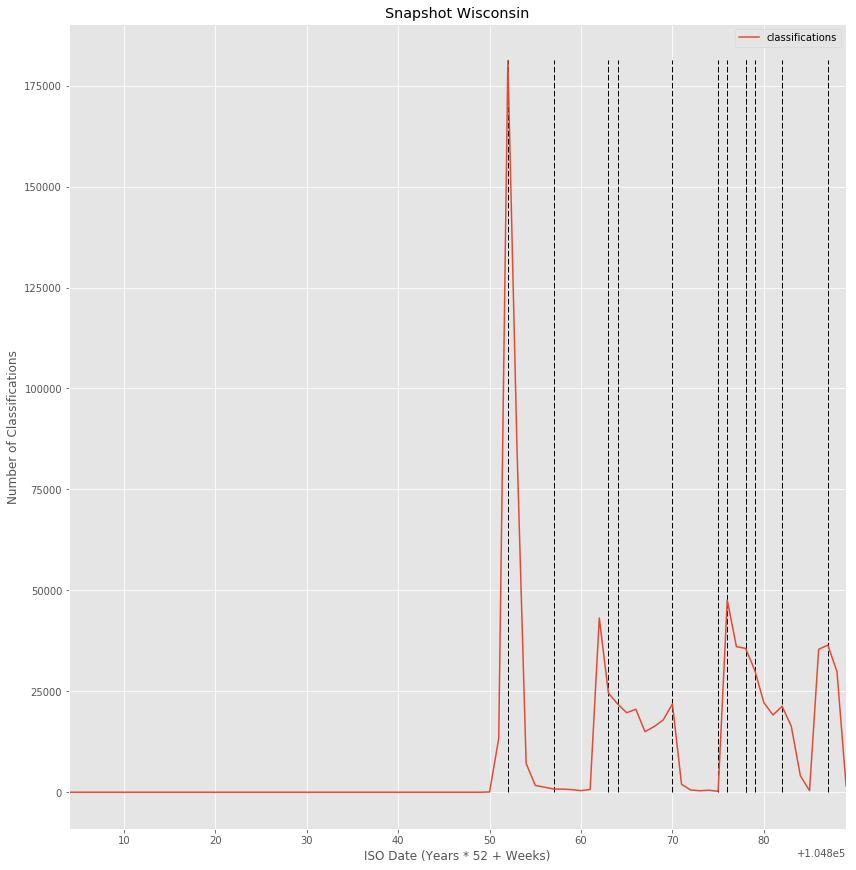

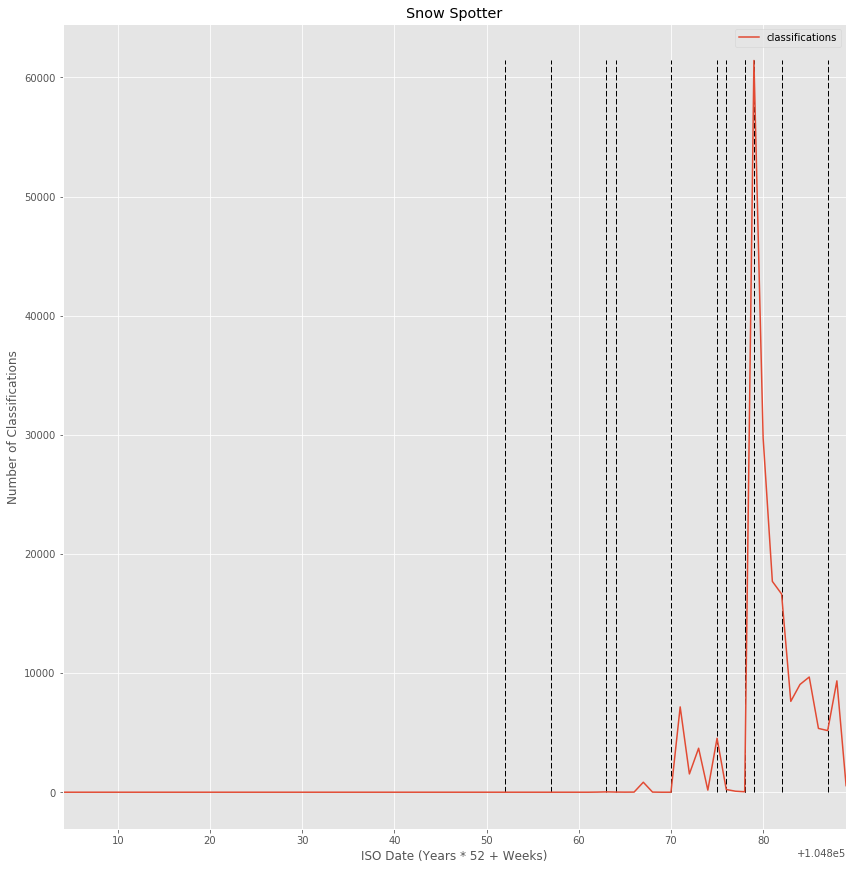

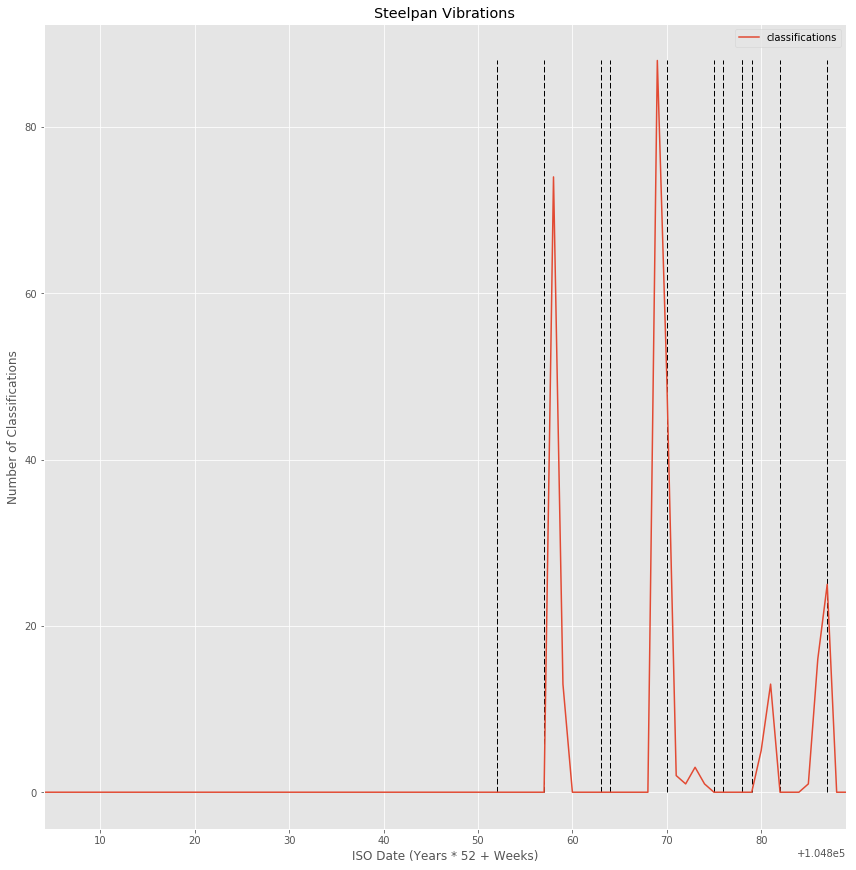

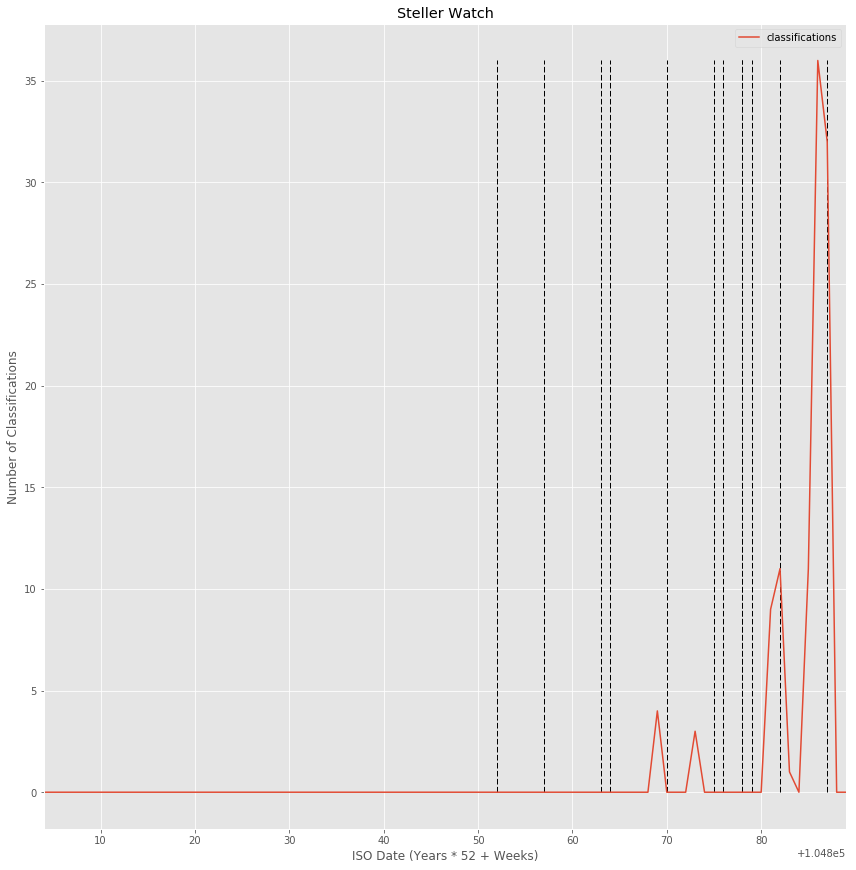

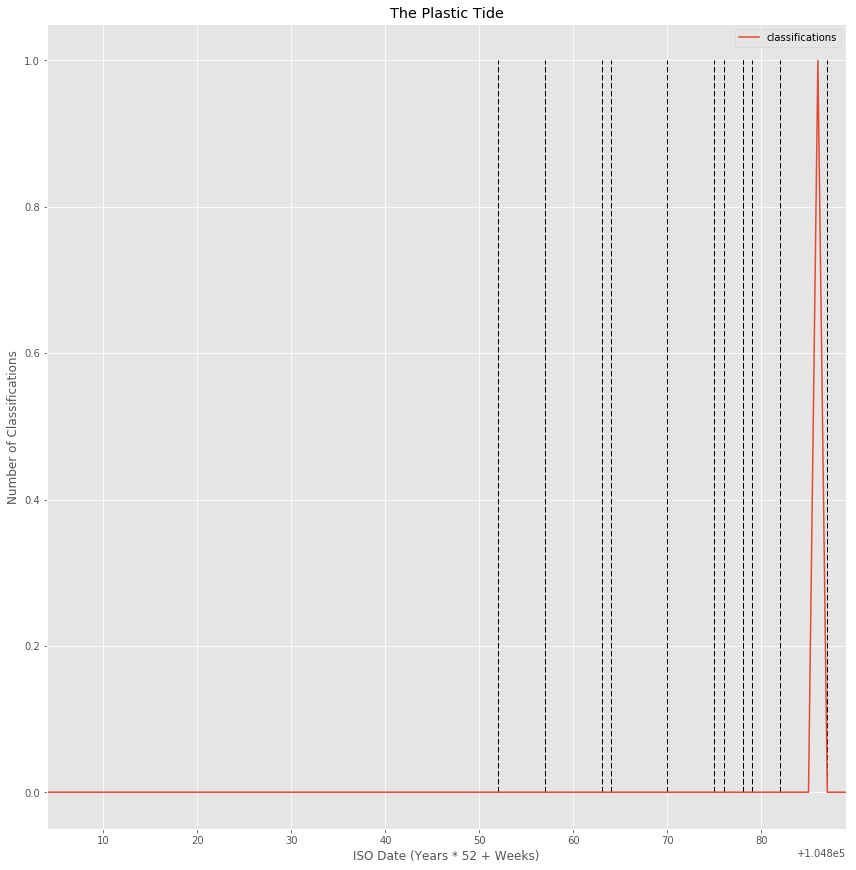

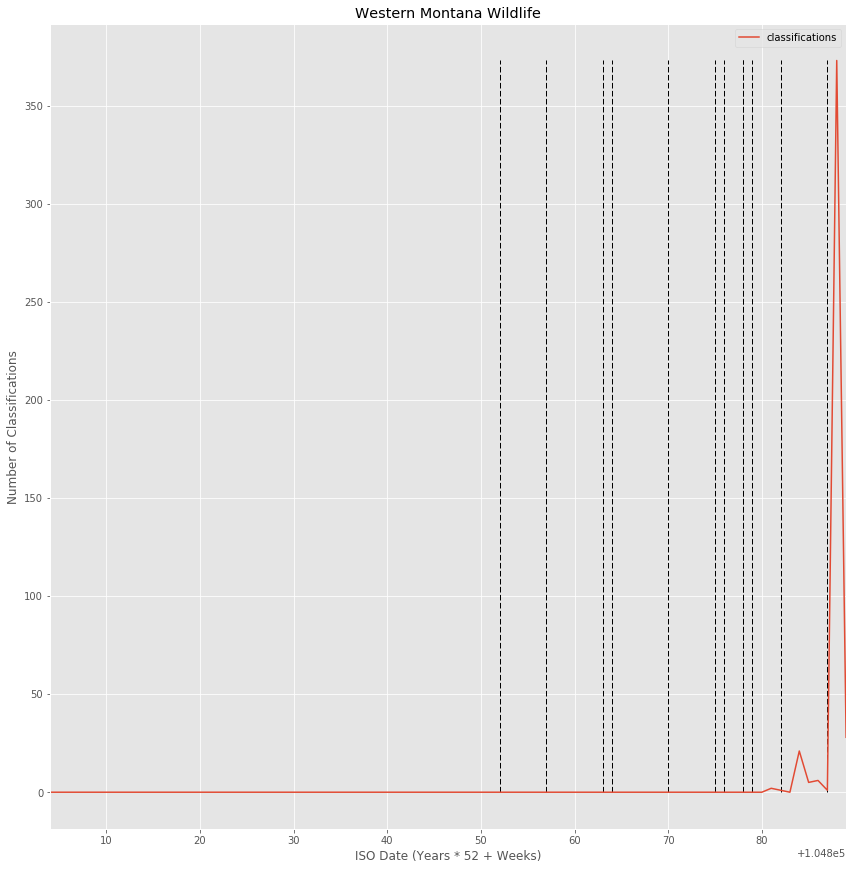

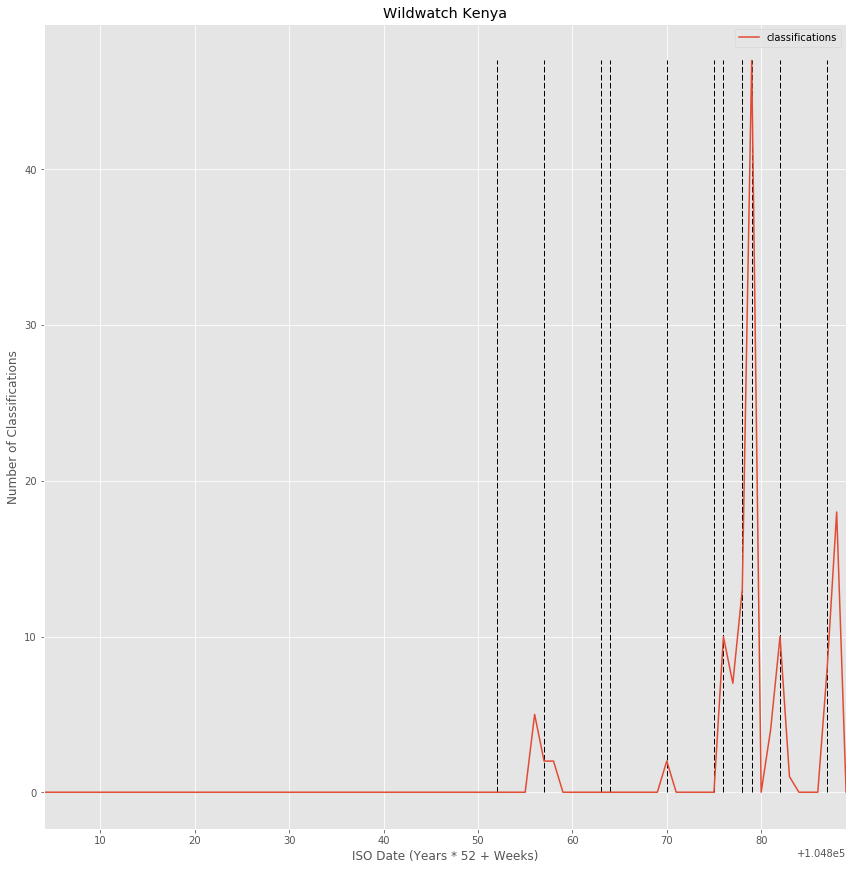

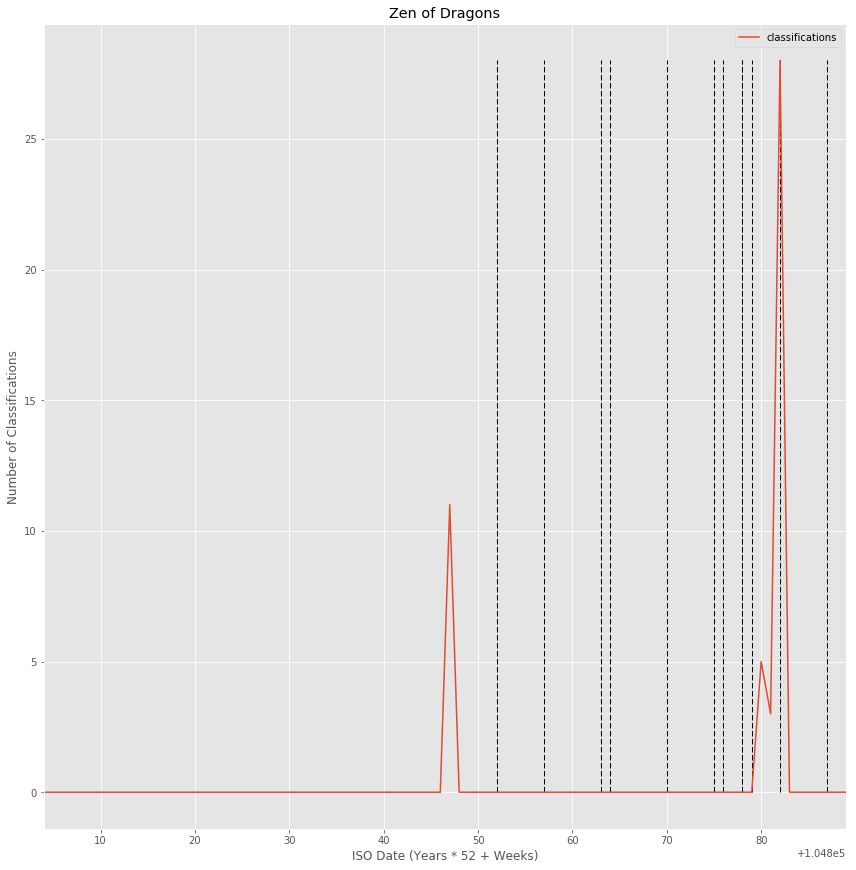

In [30]:
for project in classifications_by_week['panoptes_project_name'].unique():
    classifications_by_time(classifications_by_week.loc[classifications_by_week['panoptes_project_name'] == project],
                            email_df,
                           title=project)

In [11]:
targeted_classification_df = classification_df.loc[classification_df['panoptes_project_name'].isin(overlapping_projects['project_name'])]
targeted_classifications_by_week = count_classifications_per_week(targeted_classification_df)

In [16]:
def targeted_classifications_by_time(classifications_by_week, email_df, title=None):
    target_email_week = email_df.loc[email_df['project'].str.lower().isin(classifications_by_week['panoptes_project_name'].str.lower())]['iso_week'].tolist()
    if len(target_email_week) < 1:
        return
    classifications_by_week = classifications_by_week.loc[classifications_by_week['iso_week'] >= (target_email_week[0] - 4)]
    if len(classifications_by_week) < 1:
        return
    classifications_by_week.plot(x='iso_week',y='classifications',figsize=(6,3))

    plt.vlines(x=email_df.loc[email_df['iso_week'] < classifications_by_week['iso_week'].max()]['iso_week'].tolist(),
               ymin=0,
               ymax=classifications_by_week['classifications'].max(),
               linestyles='dotted',
               lw=1)

    plt.vlines(x=email_df.loc[email_df['project'].str.lower().isin(classifications_by_week['panoptes_project_name'].str.lower())]['iso_week'].tolist(),
           ymin=0,
           ymax=classifications_by_week['classifications'].max(),
           linestyles='solid',
           lw=1)

    plt.xlabel('ISO Date (Years * 52 + Weeks)')
    plt.ylabel('Number of Classifications')
    plt.tight_layout()

    if title:
        plt.title(title)

# Time series for each project, showing number of classifications per week for *targeted projects*.  Solid lines indicate the email that targeted this project.

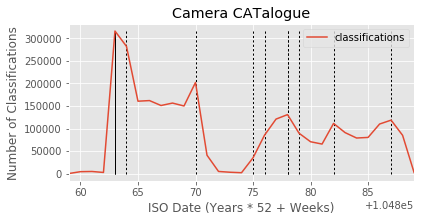

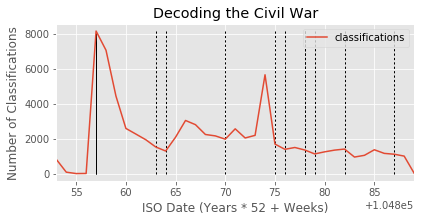

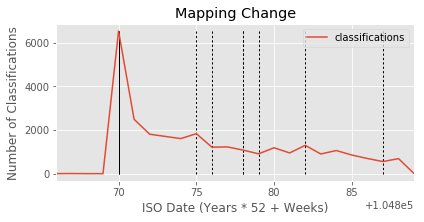

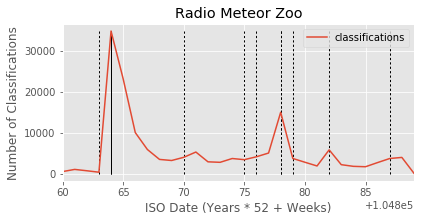

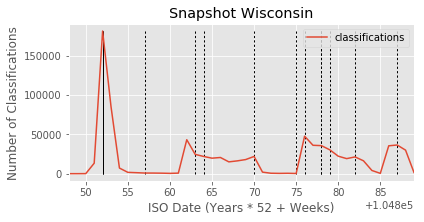

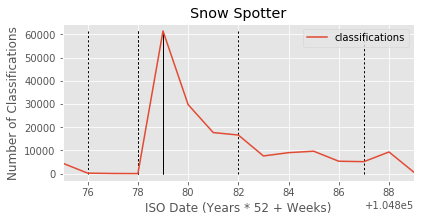

In [17]:
for project in targeted_classifications_by_week['panoptes_project_name'].unique():
    targeted_classifications_by_time(targeted_classifications_by_week.loc[targeted_classifications_by_week['panoptes_project_name'] == project],
                            email_df,
                            title=project)